### Loading the Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta

#importing sql library
from sqlalchemy import create_engine

data = pd.read_csv("./Data/Data.csv")
print(data.shape)
data.head()

(944468, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### EDA and Preprocessing Data

In [2]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 732567 entries, 0 to 944467
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      732567 non-null  object 
 1   StockCode    732567 non-null  object 
 2   Description  732567 non-null  object 
 3   Quantity     732567 non-null  int64  
 4   InvoiceDate  732567 non-null  object 
 5   Price        732567 non-null  float64
 6   Customer ID  732567 non-null  float64
 7   Country      732567 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 50.3+ MB


In [3]:
data                = data[data['Invoice'].apply(lambda x: 'C' not in x)]    
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Date']        = data['InvoiceDate'].apply(lambda x: x.date())
data['Month']       = data['InvoiceDate'].dt.month
data['Year']        = data['InvoiceDate'].dt.year
data['Month_Year']  = data['Date'].apply(lambda x: x.replace(day=1))
data['Tot_Price']   = data['Quantity']*data['Price']
data.rename(columns = {"Customer ID": "Customer_ID"}, inplace=True)
print(data.shape)
data.head()

(715226, 13)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Date,Month,Year,Month_Year,Tot_Price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01,12,2009,2009-12-01,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01,12,2009,2009-12-01,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01,12,2009,2009-12-01,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-12-01,12,2009,2009-12-01,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-12-01,12,2009,2009-12-01,30.0


In [4]:
print(data['Customer_ID'].nunique())
print(data['Invoice'].nunique())
print(data['StockCode'].nunique())
print(data['Country'].nunique())

5719
34236
4608
41


### Month-on-Month Analysis

In [54]:
month_year_df = data.groupby(['Month_Year'], as_index=False).agg({'Invoice': pd.Series.nunique, 
                                                  'Customer_ID': pd.Series.nunique, 
                                                  'Quantity': 'mean', 
                                                  'Tot_Price': 'mean'})
month_year_df['Month_Year'] = month_year_df['Month_Year'].apply(lambda x: x.strftime("%b-%Y"))
month_year_df = month_year_df.rename(columns={'Customer_ID':'Unique Customers', 
                                               'Invoice': 'Unique Invoices', 
                                               'Quantity': 'Average Quantity', 
                                               'Tot_Price': 'Average Price'})
month_year_df.head()

,Month_Year,Unique Invoices,Unique Customers,Average Quantity,Average Price
0,Dec-2009,1512,955,13.167806,22.573533
1,Jan-2010,1011,720,17.246540,25.898265
2,Feb-2010,1106,774,16.138833,21.897359
3,Mar-2010,1524,1057,15.797785,21.929285
4,Apr-2010,1329,942,13.065663,22.060893


<AxesSubplot:>

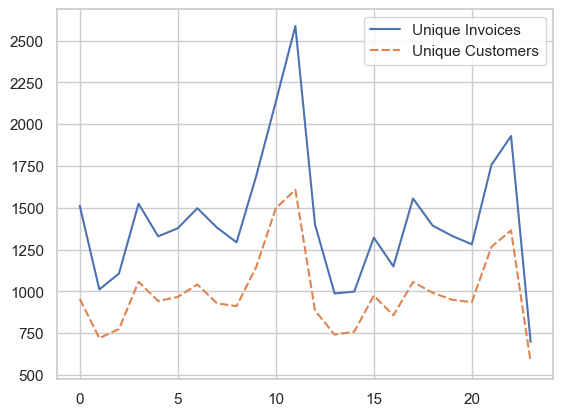

In [55]:
sns.lineplot(data=month_year_df[['Month_Year', 'Unique Invoices', 'Unique Customers']])

<AxesSubplot:>

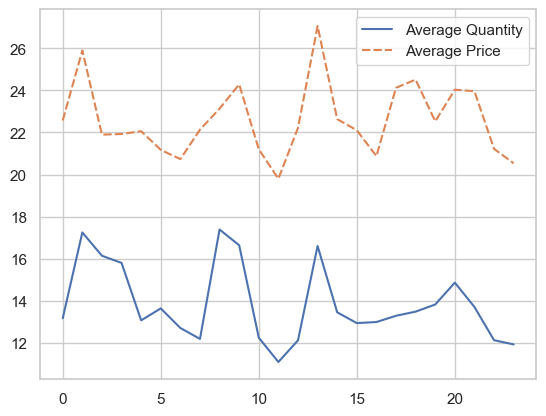

In [56]:
sns.lineplot(data=month_year_df[['Month_Year', 'Average Quantity', 'Average Price']])

### Feature Engineering

Converting DataFrame to SQL and creating features using queries

In [5]:
engine = create_engine('sqlite://', echo = False)

In [6]:
month_start = datetime(2009,12,1).date()
month_end = datetime(2011,7,1).date()

training_frames = []
while month_start <= month_end:
    start_month = month_start
    curr_month  = month_start + relativedelta(months=4)
    
    X_df     =  data[(data['Month_Year'] >= start_month) & (data['Month_Year'] < curr_month)]
    
    cat_feat = X_df.drop_duplicates(['Invoice', 'Customer_ID'])
    grp_obj  = cat_feat.groupby(['Customer_ID'], as_index=False)
    cat_feat = grp_obj['Month', 'Country'].agg({'Month': lambda x:x.value_counts().index[0], 
                                                'Country': lambda x:x.value_counts().index[0]})
    cat_feat = cat_feat.rename(columns={"Month": "Freq_Month", "Country": "Freq_Country"})
    
    X_df['CURR_MONTH'] = curr_month
    
    X_df.to_sql('e_com', con = engine, if_exists='replace')
    
    query_1 = """select * 
        , case when Date >= DATE(CURR_MONTH, '-1 month') and Date < CURR_MONTH then 1 else 0 end AS PAST1MONTH
        , case when Date >= DATE(CURR_MONTH, '-2 month') and Date < CURR_MONTH then 1 else 0 end AS PAST2MONTHS
        , case when Date >= DATE(CURR_MONTH, '-3 month') and Date < CURR_MONTH then 1 else 0 end AS PAST3MONTHS
        from e_com"""
    
    X_df = pd.read_sql_query(query_1, con = engine)
    X_df.to_sql('e_com', con = engine, if_exists='replace')

    query_2 = """select Customer_ID, Invoice,

            count(distinct case when PAST1MONTH = 1 then StockCode else 0 end) as CNT_Product_C1M,
            count(distinct case when PAST2MONTHS = 1 then StockCode else 0 end) as CNT_Product_C2M,
            count(distinct case when PAST3MONTHS = 1 then StockCode else 0 end) as CNT_Product_C3M,

            sum(case when PAST1MONTH = 1 then Quantity else 0 end) as QNT_INV_SUM1M,
            sum(case when PAST2MONTHS = 1 then Quantity else 0 end) as QNT_INV_SUM2M,
            sum(case when PAST3MONTHS = 1 then Quantity else 0 end) as QNT_INV_SUM3M,

            sum(case when PAST1MONTH = 1 then Tot_Price else 0 end) as PRI_INV_SUM1M,
            sum(case when PAST2MONTHS = 1 then Tot_Price else 0 end) as PRI_INV_SUM2M,
            sum(case when PAST3MONTHS = 1 then Tot_Price else 0 end) as PRI_INV_SUM3M

            from e_com
            group by Customer_ID, Invoice
           """

    X_df   = pd.read_sql_query(query_2, con = engine)
    X_df.to_sql('e_com', con = engine, if_exists='replace')

    query_3 = """select Customer_ID,

            count(distinct Invoice) as TOT_INVOICE_COUNT,

            avg(CNT_Product_C1M) as AVG_Distict_Product_C1M,
            avg(CNT_Product_C2M) as AVG_Distict_Product_C2M,
            avg(CNT_Product_C3M) as AVG_Distict_Product_C3M,

            SUM(QNT_INV_SUM1M) as TOT_QNT_INV_SUM1M,
            SUM(QNT_INV_SUM2M) as TOT_QNT_INV_SUM2M,
            SUM(QNT_INV_SUM3M) as TOT_QNT_INV_SUM3M,

            avg(QNT_INV_SUM1M) as AVG_QNT_INV_SUM1M,
            avg(QNT_INV_SUM2M) as AVG_QNT_INV_SUM2M,
            avg(QNT_INV_SUM3M) as AVG_QNT_INV_SUM3M,

            max(QNT_INV_SUM1M) as MAX_QNT_INV_SUM1M,
            max(QNT_INV_SUM2M) as MAX_QNT_INV_SUM2M,
            max(QNT_INV_SUM3M) as MAX_QNT_INV_SUM3M,

            min(QNT_INV_SUM1M) as MIN_QNT_INV_SUM1M,
            min(QNT_INV_SUM2M) as MIN_QNT_INV_SUM2M,
            min(QNT_INV_SUM3M) as MIN_QNT_INV_SUM3M,

            SUM(PRI_INV_SUM1M) as TOT_PRI_INV_SUM1M,
            SUM(PRI_INV_SUM2M) as TOT_PRI_INV_SUM2M,
            SUM(PRI_INV_SUM3M) as TOT_PRI_INV_SUM3M,

            avg(PRI_INV_SUM1M) as AVG_PRI_INV_SUM1M,
            avg(PRI_INV_SUM2M) as AVG_PRI_INV_SUM2M,
            avg(PRI_INV_SUM3M) as AVG_PRI_INV_SUM3M,

            max(PRI_INV_SUM1M) as MAX_PRI_INV_SUM1M,
            max(PRI_INV_SUM2M) as MAX_PRI_INV_SUM2M,
            max(PRI_INV_SUM3M) as MAX_PRI_INV_SUM3M,

            min(PRI_INV_SUM1M) as MIN_PRI_INV_SUM1M,
            min(PRI_INV_SUM2M) as MIN_PRI_INV_SUM2M,
            min(PRI_INV_SUM3M) as MIN_PRI_INV_SUM3M

            from e_com
            group by Customer_ID
           """

    X_df   = pd.read_sql_query(query_3, con = engine)
    
    # creating target
    unique_Y_Cust = data[data['Month_Year'] == curr_month]['Customer_ID'].unique()
    Y_df   = pd.DataFrame({"Customer_ID": unique_Y_Cust, 
                           "Score": np.full((1, len(unique_Y_Cust)), 1)[0]})
    
    X_df   = X_df.merge(cat_feat, on=['Customer_ID'], how='left')
    # merging features with taget
    df = X_df.merge(Y_df, on=['Customer_ID'], how='left')
    df.fillna(0, inplace=True)
    training_frames.append(df)
    
    print("DONE for MONTH", month_start)
    print("Unique Customers", df['Customer_ID'].nunique())
    month_start = month_start + relativedelta(months=1)    

DONE for MONTH 2009-12-01
Unique Customers 2157
DONE for MONTH 2010-01-01
Unique Customers 2163
DONE for MONTH 2010-02-01
Unique Customers 2289
DONE for MONTH 2010-03-01
Unique Customers 2426
DONE for MONTH 2010-04-01
Unique Customers 2341
DONE for MONTH 2010-05-01
Unique Customers 2313
DONE for MONTH 2010-06-01
Unique Customers 2410
DONE for MONTH 2010-07-01
Unique Customers 2765
DONE for MONTH 2010-08-01
Unique Customers 3123
DONE for MONTH 2010-09-01
Unique Customers 3058
DONE for MONTH 2010-10-01
Unique Customers 2838
DONE for MONTH 2010-11-01
Unique Customers 2492
DONE for MONTH 2010-12-01
Unique Customers 2134
DONE for MONTH 2011-01-01
Unique Customers 2137
DONE for MONTH 2011-02-01
Unique Customers 2247
DONE for MONTH 2011-03-01
Unique Customers 2341
DONE for MONTH 2011-04-01
Unique Customers 2304
DONE for MONTH 2011-05-01
Unique Customers 2308
DONE for MONTH 2011-06-01
Unique Customers 2479
DONE for MONTH 2011-07-01
Unique Customers 2743


### Compiling Training Data

In [7]:
training_data = pd.concat(training_frames)
print(training_data.shape)
print(training_data['Score'].value_counts())
training_data.head(10)

(49068, 32)
0.0    34972
1.0    14096
Name: Score, dtype: int64


,Customer_ID,TOT_INVOICE_COUNT,AVG_Distict_Product_C1M,AVG_Distict_Product_C2M,AVG_Distict_Product_C3M,TOT_QNT_INV_SUM1M,TOT_QNT_INV_SUM2M,TOT_QNT_INV_SUM3M,AVG_QNT_INV_SUM1M,AVG_QNT_INV_SUM2M,...,AVG_PRI_INV_SUM3M,MAX_PRI_INV_SUM1M,MAX_PRI_INV_SUM2M,MAX_PRI_INV_SUM3M,MIN_PRI_INV_SUM1M,MIN_PRI_INV_SUM2M,MIN_PRI_INV_SUM3M,Freq_Month,Freq_Country,Score
0,12346.0,10,1.400000,1.400000,1.400000,5,5,25,0.500000,0.5,...,11.705000,27.05,27.05,27.05,0.00,0.00,0.00,12,United Kingdom,0.0
1,12358.0,1,1.000000,1.000000,1.000000,0,0,0,0.000000,0.0,...,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,12,Austria,0.0
2,12359.0,4,8.500000,8.500000,8.500000,168,168,168,42.000000,42.0,...,170.835000,345.60,345.60,345.60,0.00,0.00,0.00,12,Cyprus,0.0
3,12360.0,2,1.000000,5.500000,5.500000,1,101,101,0.500000,50.5,...,79.000000,40.00,118.00,118.00,0.00,40.00,40.00,2,Austria,0.0
4,12361.0,1,1.000000,1.000000,7.000000,0,0,45,0.000000,0.0,...,109.200000,0.00,0.00,109.20,0.00,0.00,109.20,1,Belgium,0.0
5,12362.0,1,1.000000,1.000000,1.000000,0,0,0,0.000000,0.0,...,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,12,Belgium,0.0
6,12366.0,1,3.000000,3.000000,3.000000,296,296,296,296.000000,296.0,...,500.240000,500.24,500.24,500.24,500.24,500.24,500.24,3,Cyprus,0.0
7,12368.0,1,18.000000,18.000000,18.000000,330,330,330,330.000000,330.0,...,917.700000,917.70,917.70,917.70,917.70,917.70,917.70,3,Cyprus,0.0
8,12369.0,1,9.000000,9.000000,9.000000,209,209,209,209.000000,209.0,...,348.320000,348.32,348.32,348.32,348.32,348.32,348.32,3,Austria,0.0
9,12370.0,3,3.666667,11.666667,11.666667,80,252,252,26.666667,84.0,...,258.206667,141.06,562.96,562.96,0.00,70.60,70.60,3,Austria,0.0


### Weight of Evidence (WOE) Label Encoding

In [8]:
df_woe = pd.DataFrame(df.groupby("Freq_Country")["Score"].mean())
df_woe["WOE"] = np.log((df_woe['Score']+0.00001)/(1-(df_woe['Score'])+0.00001))
training_data["Freq_Country"] = training_data["Freq_Country"].map(df_woe["WOE"])
training_data.head()

,Customer_ID,TOT_INVOICE_COUNT,AVG_Distict_Product_C1M,AVG_Distict_Product_C2M,AVG_Distict_Product_C3M,TOT_QNT_INV_SUM1M,TOT_QNT_INV_SUM2M,TOT_QNT_INV_SUM3M,AVG_QNT_INV_SUM1M,AVG_QNT_INV_SUM2M,...,AVG_PRI_INV_SUM3M,MAX_PRI_INV_SUM1M,MAX_PRI_INV_SUM2M,MAX_PRI_INV_SUM3M,MIN_PRI_INV_SUM1M,MIN_PRI_INV_SUM2M,MIN_PRI_INV_SUM3M,Freq_Month,Freq_Country,Score
0,12346.0,10,1.4,1.4,1.4,5,5,25,0.5,0.5,...,11.705,27.05,27.05,27.05,0.0,0.0,0.0,12,-1.713099,0.0
1,12358.0,1,1.0,1.0,1.0,0,0,0,0.0,0.0,...,0.000,0.00,0.00,0.00,0.0,0.0,0.0,12,-11.512935,0.0
2,12359.0,4,8.5,8.5,8.5,168,168,168,42.0,42.0,...,170.835,345.60,345.60,345.60,0.0,0.0,0.0,12,-11.512935,0.0
3,12360.0,2,1.0,5.5,5.5,1,101,101,0.5,50.5,...,79.000,40.00,118.00,118.00,0.0,40.0,40.0,2,-11.512935,0.0
4,12361.0,1,1.0,1.0,7.0,0,0,45,0.0,0.0,...,109.200,0.00,0.00,109.20,0.0,0.0,109.2,1,-1.098586,0.0


### Train-Test Spliting

In [9]:
y = training_data['Score']
x_feat = [i for i in training_data.columns if i not in ['Score', 'Customer_ID']]
X = training_data[x_feat]
X.head()

,TOT_INVOICE_COUNT,AVG_Distict_Product_C1M,AVG_Distict_Product_C2M,AVG_Distict_Product_C3M,TOT_QNT_INV_SUM1M,TOT_QNT_INV_SUM2M,TOT_QNT_INV_SUM3M,AVG_QNT_INV_SUM1M,AVG_QNT_INV_SUM2M,AVG_QNT_INV_SUM3M,...,AVG_PRI_INV_SUM2M,AVG_PRI_INV_SUM3M,MAX_PRI_INV_SUM1M,MAX_PRI_INV_SUM2M,MAX_PRI_INV_SUM3M,MIN_PRI_INV_SUM1M,MIN_PRI_INV_SUM2M,MIN_PRI_INV_SUM3M,Freq_Month,Freq_Country
0,10,1.4,1.4,1.4,5,5,25,0.5,0.5,2.5,...,2.705,11.705,27.05,27.05,27.05,0.0,0.0,0.0,12,-1.713099
1,1,1.0,1.0,1.0,0,0,0,0.0,0.0,0.0,...,0.000,0.000,0.00,0.00,0.00,0.0,0.0,0.0,12,-11.512935
2,4,8.5,8.5,8.5,168,168,168,42.0,42.0,42.0,...,170.835,170.835,345.60,345.60,345.60,0.0,0.0,0.0,12,-11.512935
3,2,1.0,5.5,5.5,1,101,101,0.5,50.5,50.5,...,79.000,79.000,40.00,118.00,118.00,0.0,40.0,40.0,2,-11.512935
4,1,1.0,1.0,7.0,0,0,45,0.0,0.0,45.0,...,0.000,109.200,0.00,0.00,109.20,0.0,0.0,109.2,1,-1.098586


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25, random_state=2022)

### Model Building

In [38]:
import xgboost as xgb

# model = xgb.XGBClassifier(random_state=2022)

model = xgb.XGBClassifier(n_estimators=200,
                          max_depth=3,
                          gamma=9,
                          objective='binary:logistic',
                          colsample_bytree=0.6,
                          subsample=1,
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False, 
                          random_state=2022)

model.fit(X_train , y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, eval_metric='auc', gamma=9, gpu_id=-1,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=2022,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, ...)

### Model Evaluation

In [39]:
from sklearn.metrics import roc_auc_score

y_train_pred = model.predict_proba(X_train)[:,1]
print("Train AUC Score is",roc_auc_score(y_train,y_train_pred))

y_test_pred = model.predict_proba(X_test)[:,1]
print("Test AUC Score is",roc_auc_score(y_test,y_test_pred))

Train AUC Score is 0.7433425435193479
Test AUC Score is 0.716932553664141


### Plotting AUC Curve

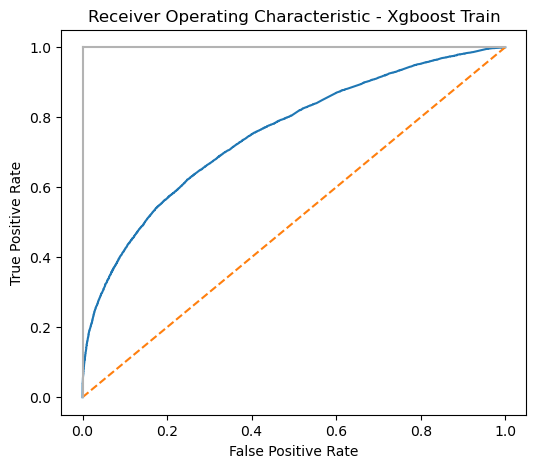

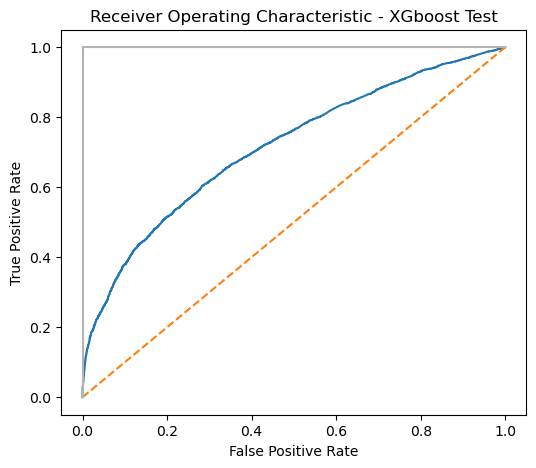

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_train, y_train_pred)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_test_pred)

plt.subplots(1, figsize=(6,5))
plt.title('Receiver Operating Characteristic - Xgboost Train')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(6,5))
plt.title('Receiver Operating Characteristic - XGboost Test')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Getting Feature Importances

In [14]:
d = model.get_booster().get_score(importance_type= 'gain')
l = [{'Feature': i, 'Information_gain': d[i]} for i in d]
gain_df = pd.DataFrame(l)
gain_df.sort_values(by=['Information_gain'], ascending=False, inplace=True)
gain_df.to_csv('feature_importances.csv')
gain_df

,Feature,Information_gain
0,TOT_INVOICE_COUNT,267.909241
18,TOT_PRI_INV_SUM3M,41.340847
20,AVG_PRI_INV_SUM2M,18.664450
28,Freq_Month,18.579975
15,MIN_QNT_INV_SUM3M,15.327542
27,MIN_PRI_INV_SUM3M,14.740294
6,TOT_QNT_INV_SUM3M,13.532208
1,AVG_Distict_Product_C1M,12.890003
2,AVG_Distict_Product_C2M,11.933421
19,AVG_PRI_INV_SUM1M,11.578625


<AxesSubplot:xlabel='Information_gain', ylabel='Feature'>

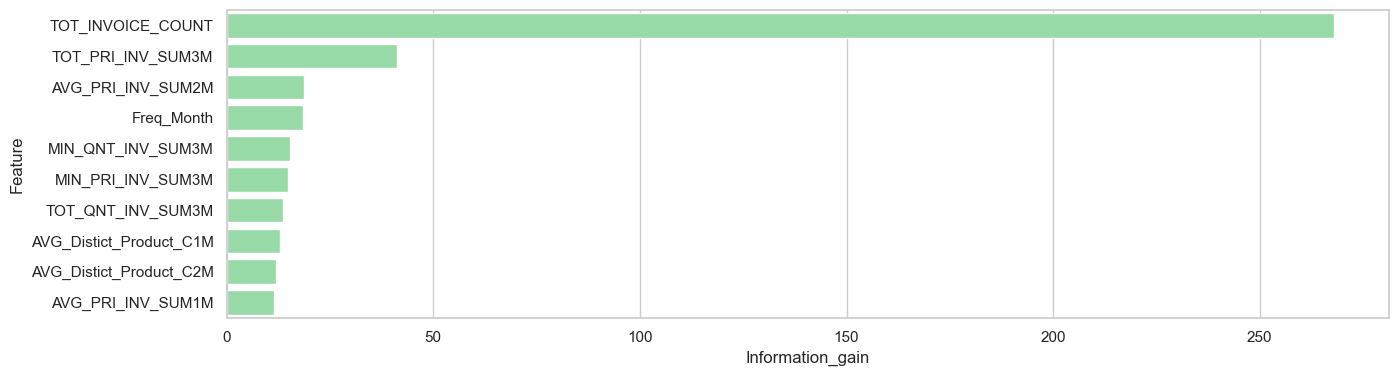

In [43]:
gain_df = gain_df[['Feature', 'Information_gain']][:10]

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 4))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="Information_gain", y="Feature", data=gain_df, label="Total", color="g")

### Getting Predictions

In [15]:
training_data['Probability'] = model.predict_proba(training_data[x_feat])[:,1]
training_data = training_data.drop_duplicates(['Customer_ID'], keep='last')
training_data.head()

,Customer_ID,TOT_INVOICE_COUNT,AVG_Distict_Product_C1M,AVG_Distict_Product_C2M,AVG_Distict_Product_C3M,TOT_QNT_INV_SUM1M,TOT_QNT_INV_SUM2M,TOT_QNT_INV_SUM3M,AVG_QNT_INV_SUM1M,AVG_QNT_INV_SUM2M,...,MAX_PRI_INV_SUM1M,MAX_PRI_INV_SUM2M,MAX_PRI_INV_SUM3M,MIN_PRI_INV_SUM1M,MIN_PRI_INV_SUM2M,MIN_PRI_INV_SUM3M,Freq_Month,Freq_Country,Score,Probability
30,12443.0,1,1.0,1.0,1.0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12,-1.252731,0.0,0.147198
42,12487.0,1,1.0,1.0,1.0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12,-11.512935,0.0,0.199200
79,12636.0,1,1.0,1.0,1.0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12,-11.512935,0.0,0.199200
170,12934.0,1,1.0,1.0,1.0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12,-1.713099,0.0,0.147198
173,12941.0,1,1.0,1.0,1.0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12,-1.713099,0.0,0.147198


In [16]:
print(training_data.shape)

(5661, 33)


In [17]:
training_data[['Customer_ID', 'Probability']].to_csv("Submission.csv")